In [ ]:
import transformers
print(transformers.__version__)  # 반드시 4.40 이상이어야 합니다!


4.54.0


In [ ]:
from transformers import TrainingArguments

args = TrainingArguments(
    output_dir="./test",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir="./test/logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    seed=42
)

print("✅ TrainingArguments 생성 성공")

✅ TrainingArguments 생성 성공


In [ ]:
# ==============================  Colab 준비  ===============================
# 한 번만 실행: 최신 라이브러리 + RDKit

import os
os.environ["WANDB_DISABLED"] = "true"
!pip -q install -U  datasets scikit-learn accelerate wandb rdkit-pypi
!pip install -U "transformers[torch]>=4.40" --quiet
# ------------------------------  라이브러리  -------------------------------
import os
os.environ["WANDB_DISABLED"] = "true"
import os, json, random, inspect, math, warnings
from dataclasses import dataclass, asdict
import numpy as np, pandas as pd, torch, wandb
from torch.utils.data import Dataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
)

warnings.filterwarnings("ignore")
torch.backends.cuda.matmul.allow_tf32 = True  # T4 환경에서 mixed precision 성능 ↑

# ==============================  설정값  ====================================
@dataclass
class CFG:
    model_id: str = "seyonec/ChemBERTa-zinc-base-v1"   # HF public ID
    train_csv: str = "https://raw.githubusercontent.com/Parkss0/0428/refs/heads/main/dataset2.csv"           # Colab 경로
    output_dir: str = "/content/outputs/0428_chemberta_smiles"
    k_fold: int = 5
    max_length: int = 256
    batch_size: int = 32
    epochs: int = 10
    lr: float = 2e-5
    weight_decay: float = 1e-2
    grad_accum: int = 1
    seed: int = 42
    fp16: bool = torch.cuda.is_available()             # Colab GPU
    bf16: bool = False                                 # bfloat16(T4 지원X)
    wandb_project: str = "ChemBERTa_SMILES"
    save_oof: str = "oof_preds.csv"                    # stacking용

cfg = CFG()
os.makedirs(cfg.output_dir, exist_ok=True)
random.seed(cfg.seed); np.random.seed(cfg.seed); torch.manual_seed(cfg.seed)

# ==============================  모델/토크나이저  ============================
tokenizer = AutoTokenizer.from_pretrained(cfg.model_id)
base_model = AutoModelForSequenceClassification.from_pretrained(
    cfg.model_id, num_labels=2
)
print(f"[INFO] backbone loaded ({cfg.model_id}) | vocab={len(tokenizer)}")

# ==============================  데이터셋  ===================================
class SmilesDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.smi = df["canonical_smiles"].tolist()
        self.lab = df["label"].astype(int).tolist()
        self.tok, self.max = tokenizer, max_len
    def __len__(self): return len(self.smi)
    def __getitem__(self, i):
        enc = self.tok(
            self.smi[i],
            padding="max_length",
            truncation=True,
            max_length=self.max,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.lab[i])
        return item

def compute_metrics(eval_pred):
    logits, y_true = eval_pred
    y_prob = torch.softmax(torch.tensor(logits), dim=-1)[:, 1].cpu().numpy()
    return {
        "roc_auc": roc_auc_score(y_true, y_prob),
        "auprc": average_precision_score(y_true, y_prob),
        "accuracy": accuracy_score(y_true, y_prob > 0.5),
    }

# ==============================  훈련/추론 함수  =============================
from transformers import TrainingArguments

def make_args(out_dir, fold_seed):
    common = dict(
        output_dir=out_dir,
        overwrite_output_dir=True,
        num_train_epochs=10,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=64,
        eval_strategy="epoch",  # ✅ 중요!
        logging_dir=f"{out_dir}/logs",
        logging_steps=50,
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        seed=fold_seed
    )
    return TrainingArguments(**common)

def run_fold(train_df, val_df, fold_idx):
    """단일 Fold 학습 & OOF 예측"""
    # 매 Fold 새 모델 인스턴스 (가중치 reset)
    model = AutoModelForSequenceClassification.from_pretrained(
        cfg.model_id, num_labels=2
    )

    trainer = Trainer(
        model=model,
        args=make_args(os.path.join(cfg.output_dir, f"fold{fold_idx}"), cfg.seed + fold_idx),
        train_dataset=SmilesDataset(train_df, tokenizer, cfg.max_length),
        eval_dataset=SmilesDataset(val_df, tokenizer, cfg.max_length),
        compute_metrics=compute_metrics,
    )
    trainer.train()

    # ── OOF 예측 저장 ──
    preds = trainer.predict(trainer.eval_dataset)
    y_prob = torch.softmax(torch.tensor(preds.predictions), dim=-1)[:, 1].cpu().numpy()
    oof_df = val_df[["label"]].copy()
    oof_df["prob"] = y_prob
    oof_df["fold"] = fold_idx
    oof_df["idx"] = val_df.index
    return preds.metrics, oof_df

# ==============================  Main (CV)  =================================
def main():
    wandb.init(project=cfg.wandb_project, config=asdict(cfg))
    df = pd.read_csv(cfg.train_csv)          # ① 먼저 읽기
    df = df.drop(columns=[c for c in df.columns if "Unnamed" in c])  # ② 열 정리
    assert {"canonical_smiles", "label"}.issubset(df.columns), "Required columns missing!"

    skf = StratifiedKFold(n_splits=cfg.k_fold, shuffle=True, random_state=cfg.seed)
    metrics_all, oof_list = [], []

    for fold, (tr_idx, vl_idx) in enumerate(skf.split(df, df["label"])):
        train_df, val_df = df.iloc[tr_idx].reset_index(drop=True), df.iloc[vl_idx].reset_index(drop=True)
        print(f"========== Fold {fold+1}/{cfg.k_fold} ==========")
        m, oof = run_fold(train_df, val_df, fold)
        metrics_all.append(m); oof_list.append(oof)
        wandb.log({f"fold{fold}_{k}": v for k, v in m.items()})

    # ── CV 평균 기록 ──
    cv_metrics = {k: np.mean([m[k] for m in metrics_all]) for k in metrics_all[0]}
    with open(os.path.join(cfg.output_dir, "cv_metrics.json"), "w", encoding="utf-8") as f:
        json.dump(cv_metrics, f, indent=2)
    print(json.dumps(cv_metrics, indent=2))
    wandb.log({"CV_"+k: v for k, v in cv_metrics.items()})

    # ── Stacking용 OOF 파일 저장 ──
    oof_df = pd.concat(oof_list).sort_values("idx").reset_index(drop=True)
    oof_path = os.path.join(cfg.output_dir, cfg.save_oof)
    oof_df.to_csv(oof_path, index=False)
    print(f"[INFO] OOF probabilities saved ➜ {oof_path}")

    wandb.finish()

if __name__ == "__main__":
    main()


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[INFO] backbone loaded (seyonec/ChemBERTa-zinc-base-v1) | vocab=767


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: aika1108 (aika1108-korea-research-institute-of-bioscience-and-biot) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


========== Fold 1/5 ==========


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Roc Auc,Auprc,Accuracy
1,0.270100,0.253464,0.734392,0.968112,0.922392
2,0.237600,0.273281,0.750256,0.970986,0.922392
3,0.215900,0.279050,0.708836,0.964987,0.920415
4,0.134700,0.329066,0.716537,0.961070,0.909540
5,0.087800,0.469801,0.714400,0.963915,0.910529
6,0.041800,0.535005,0.667151,0.953591,0.913989
7,0.040500,0.629283,0.652882,0.951588,0.908552
8,0.019100,0.678634,0.670251,0.953140,0.899654
9,0.013400,0.690069,0.668908,0.952775,0.905586
10,0.007100,0.709735,0.670072,0.953334,0.908057


========== Fold 2/5 ==========


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Roc Auc,Auprc,Accuracy
1,0.253300,0.259564,0.754961,0.969747,0.922887
2,0.252000,0.249708,0.763099,0.972948,0.922887
3,0.187200,0.268615,0.757756,0.971632,0.909540
4,0.154800,0.351577,0.722994,0.965443,0.911023
5,0.114200,0.406687,0.724218,0.964814,0.898665
6,0.072100,0.494979,0.657460,0.952545,0.897182
7,0.040000,0.584206,0.686193,0.957506,0.902620
8,0.027200,0.638220,0.668021,0.953562,0.904597
9,0.017900,0.666295,0.681206,0.955186,0.907069
10,0.007800,0.683485,0.664303,0.951680,0.910035


========== Fold 3/5 ==========


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Roc Auc,Auprc,Accuracy
1,0.265100,0.254698,0.733753,0.966726,0.922887
2,0.226200,0.239695,0.769461,0.972207,0.922887
3,0.201800,0.294593,0.744712,0.969082,0.921404
4,0.157700,0.344128,0.706569,0.964114,0.917944
5,0.092000,0.425380,0.701068,0.960841,0.906574
6,0.051600,0.548852,0.690155,0.957986,0.905091
7,0.036900,0.629467,0.687746,0.957061,0.911518
8,0.021500,0.703584,0.662474,0.950352,0.915472
9,0.009800,0.720696,0.667508,0.951174,0.913000
10,0.013200,0.737454,0.665908,0.950455,0.914483


========== Fold 4/5 ==========


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Roc Auc,Auprc,Accuracy
1,0.239100,0.245611,0.740767,0.968428,0.922887
2,0.231500,0.299827,0.700181,0.961579,0.922887
3,0.186000,0.287847,0.724994,0.966415,0.910035
4,0.142800,0.352679,0.712199,0.963962,0.908057
5,0.078000,0.427455,0.701205,0.961878,0.900643
6,0.058700,0.535022,0.731052,0.965795,0.907069
7,0.028100,0.625957,0.721329,0.962963,0.907563
8,0.020300,0.657891,0.722055,0.962700,0.905586
9,0.018500,0.693561,0.703702,0.960134,0.908057
10,0.007800,0.713345,0.702878,0.959770,0.908552


========== Fold 5/5 ==========


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Roc Auc,Auprc,Accuracy
1,0.251900,0.259332,0.724940,0.965512,0.916419
2,0.232900,0.270929,0.718577,0.962458,0.916419
3,0.206000,0.291242,0.710204,0.963325,0.904550
4,0.150300,0.370173,0.697883,0.960977,0.898615
5,0.087000,0.472750,0.697493,0.958583,0.906034
6,0.048100,0.566333,0.686193,0.957354,0.907023
7,0.048400,0.650524,0.675202,0.957212,0.911474
8,0.030700,0.704268,0.692129,0.958058,0.910485
9,0.017400,0.724536,0.693613,0.958952,0.902572
10,0.007200,0.748138,0.688237,0.958357,0.909001


{
  "test_loss": 0.24956215023994446,
  "test_roc_auc": 0.7465317182034689,
  "test_auprc": 0.9694413045037976,
  "test_accuracy": 0.9214944556981459,
  "test_runtime": 13.67996,
  "test_samples_per_second": 147.8808,
  "test_steps_per_second": 2.3394
}
[INFO] OOF probabilities saved ➜ /content/outputs/0428_chemberta_smiles/oof_preds.csv


CV_test_accuracy,▁
CV_test_auprc,▁
CV_test_loss,▁
CV_test_roc_auc,▁
CV_test_runtime,▁
CV_test_samples_per_second,▁
CV_test_steps_per_second,▁
fold0_test_accuracy,▁
fold0_test_auprc,▁
fold0_test_loss,▁
fold0_test_roc_auc,▁


In [ ]:
files.download('/content/outputs/0428_chemberta_smiles/cv_metrics.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

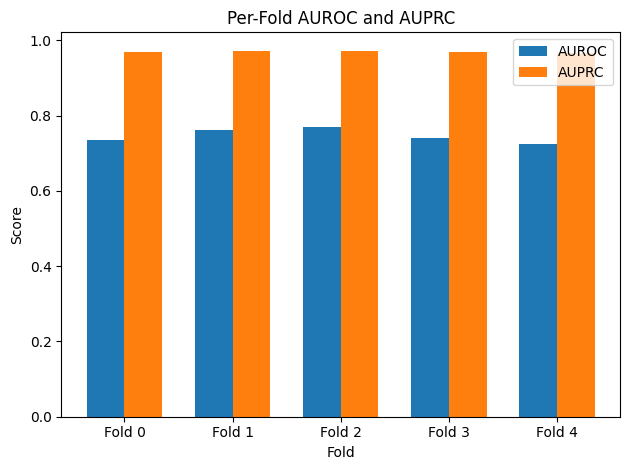

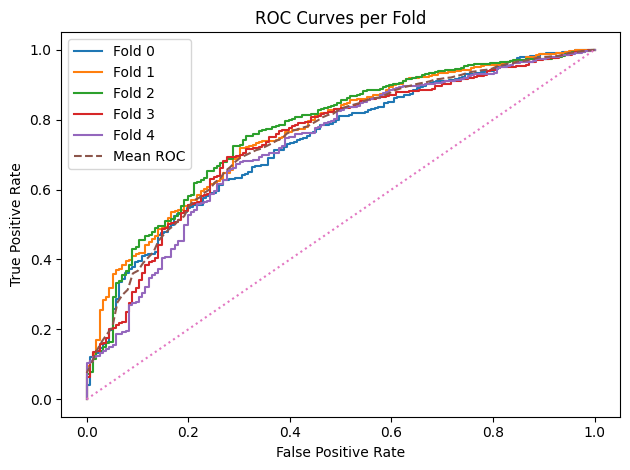

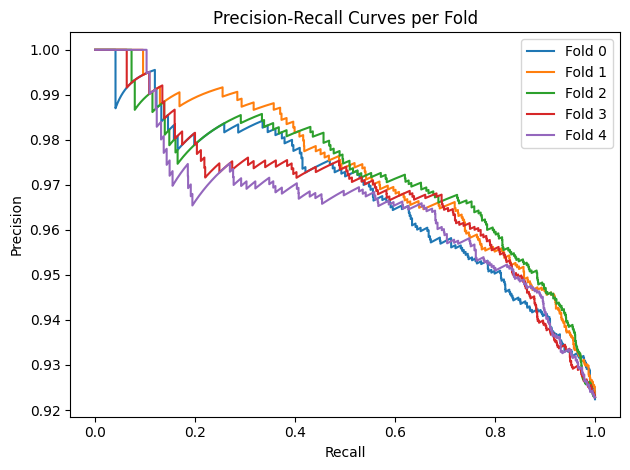

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    roc_curve,
    precision_recall_curve
)

# 파일 경로 설정
oof_path = "/content/outputs/0428_chemberta_smiles/oof_preds.csv"

# OOF 예측 데이터 로드
oof = pd.read_csv(oof_path)

# 폴드별 지표 계산
folds = sorted(oof["fold"].unique())
auroc_list, auprc_list, acc_list = [], [], []

for fold in folds:
    df_fold = oof[oof["fold"] == fold]
    y_true = df_fold["label"].values
    y_prob = df_fold["prob"].values

    auroc = roc_auc_score(y_true, y_prob)
    auprc = average_precision_score(y_true, y_prob)
    acc = accuracy_score(y_true, y_prob > 0.5)

    auroc_list.append(auroc)
    auprc_list.append(auprc)
    acc_list.append(acc)

# 1. 폴드별 AUROC 및 AUPRC 바 차트
x = np.arange(len(folds))
width = 0.35

fig1, ax1 = plt.subplots()
ax1.bar(x - width/2, auroc_list, width, label="AUROC")
ax1.bar(x + width/2, auprc_list, width, label="AUPRC")
ax1.set_xticks(x)
ax1.set_xticklabels([f"Fold {f}" for f in folds])
ax1.set_ylabel("Score")
ax1.set_xlabel("Fold")
ax1.set_title("Per-Fold AUROC and AUPRC")
ax1.legend()
plt.tight_layout()
plt.show()

# 2. 폴드별 ROC 커브
fig2, ax2 = plt.subplots()
mean_fpr = np.linspace(0, 1, 100)
tprs = []

for fold in folds:
    df_fold = oof[oof["fold"] == fold]
    fpr, tpr, _ = roc_curve(df_fold["label"], df_fold["prob"])
    ax2.plot(fpr, tpr, label=f"Fold {fold}")
    tprs.append(np.interp(mean_fpr, fpr, tpr))

mean_tpr = np.mean(tprs, axis=0)
ax2.plot(mean_fpr, mean_tpr, linestyle="--", label="Mean ROC")
ax2.plot([0, 1], [0, 1], linestyle=":")
ax2.set_xlabel("False Positive Rate")
ax2.set_ylabel("True Positive Rate")
ax2.set_title("ROC Curves per Fold")
ax2.legend()
plt.tight_layout()
plt.show()

# 3. 폴드별 Precision-Recall 커브
fig3, ax3 = plt.subplots()

for fold in folds:
    df_fold = oof[oof["fold"] == fold]
    precision, recall, _ = precision_recall_curve(df_fold["label"], df_fold["prob"])
    ax3.plot(recall, precision, label=f"Fold {fold}")

ax3.set_xlabel("Recall")
ax3.set_ylabel("Precision")
ax3.set_title("Precision-Recall Curves per Fold")
ax3.legend()
plt.tight_layout()
plt.show()

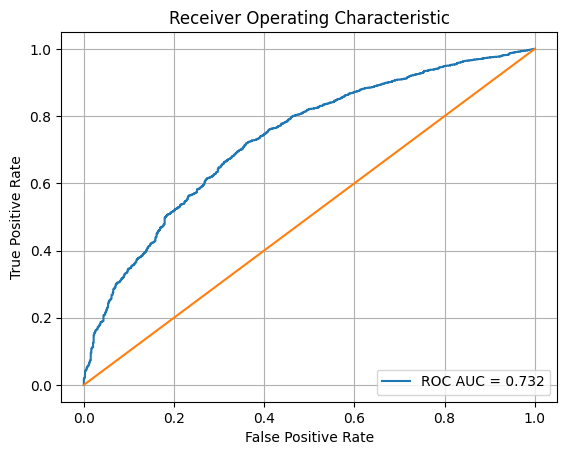

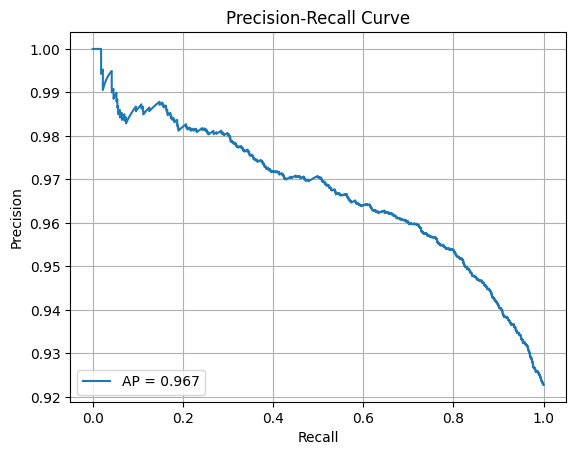

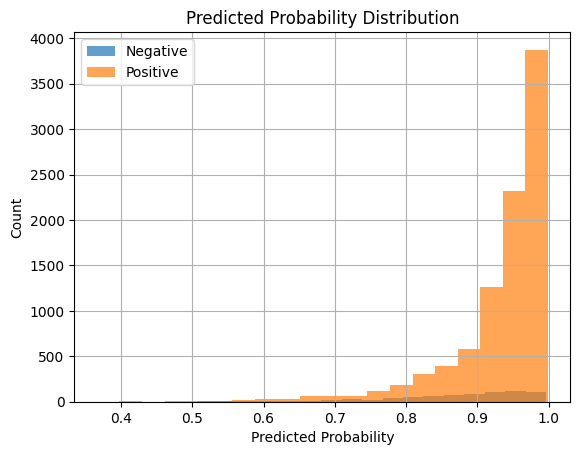

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Load OOF predictions
oof_path = "/content/outputs/0428_chemberta_smiles/oof_preds.csv"
df = pd.read_csv(oof_path)
y_true = df["label"]
y_prob = df["prob"]

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1])
plt.title("Receiver Operating Characteristic")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_prob)
pr_auc = average_precision_score(y_true, y_prob)

plt.figure()
plt.plot(recall, precision, label=f"AP = {pr_auc:.3f}")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

# Probability Distribution by Class
plt.figure()
plt.hist(y_prob[y_true == 0], bins=20, alpha=0.7, label="Negative")
plt.hist(y_prob[y_true == 1], bins=20, alpha=0.7, label="Positive")
plt.title("Predicted Probability Distribution")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.show()


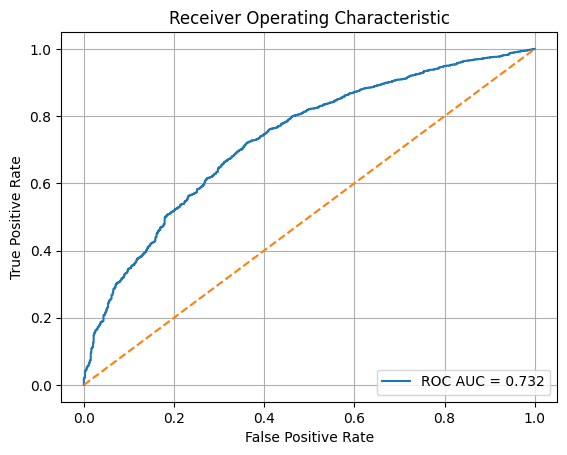

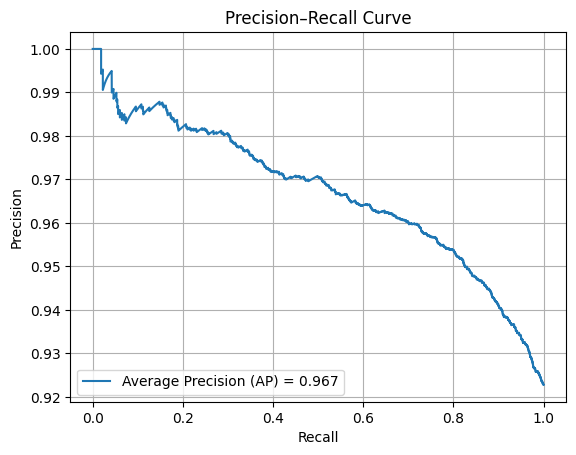

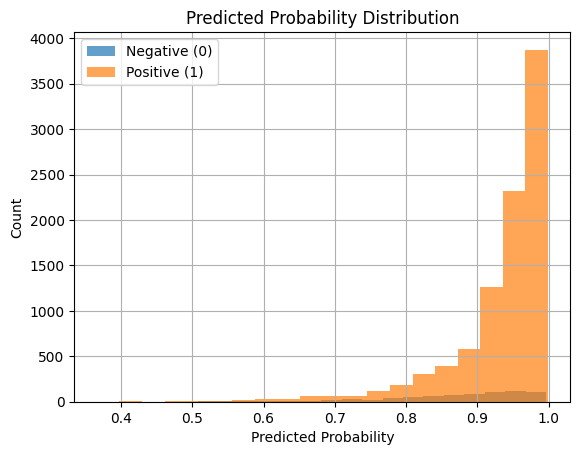

In [ ]:
import pandas as pd
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# 1) OOF 예측 불러오기
oof_path = "/content/outputs/0428_chemberta_smiles/oof_preds.csv"  # 실제 경로로 수정 가능
df = pd.read_csv(oof_path)
y_true = df["label"]
y_prob = df["prob"]

# 2) ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("Receiver Operating Characteristic")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 3) Precision–Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_prob)
pr_auc = average_precision_score(y_true, y_prob)

plt.figure()
plt.plot(recall, precision, label=f"Average Precision (AP) = {pr_auc:.3f}")
plt.title("Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

# 4) Predicted Probability Distribution by True Class
plt.figure()
plt.hist(y_prob[y_true == 0], bins=20, alpha=0.7, label="Negative (0)")
plt.hist(y_prob[y_true == 1], bins=20, alpha=0.7, label="Positive (1)")
plt.title("Predicted Probability Distribution")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import wandb, json, pandas as pd

# 이미 run이 살아 있다면 이걸로 가져오고, 아니면 init
run = wandb.run or wandb.init()

# Summary 전체를 dict로 가져오기
metrics = run.summary._as_dict()

# JSON 저장
json_path = "/content/outputs/0428_chemberta_smiles/run_summary.json"
with open(json_path, "w") as f:
    json.dump(metrics, f, indent=2)
print(f"▶ JSON 저장됨: {json_path}")

# CSV 저장
df = pd.DataFrame.from_dict(metrics, orient="index", columns=["value"])
csv_path = "/content/outputs/0428_chemberta_smiles/run_summary.csv"
df.to_csv(csv_path)
print(f"▶ CSV 저장됨: {csv_path}")


▶ JSON 저장됨: /content/outputs/0428_chemberta_smiles/run_summary.json
▶ CSV 저장됨: /content/outputs/0428_chemberta_smiles/run_summary.csv


In [ ]:
from google.colab import files

files.download('/content/outputs/0428_chemberta_smiles/run_summary.json')
files.download('/content/outputs/0428_chemberta_smiles/run_summary.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download('/content/outputs/0428_chemberta_smiles/oof_preds.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt

def plot_cv_metrics(metrics_all):
    metrics_df = pd.DataFrame(metrics_all)

    plt.figure(figsize=(12, 4))

    for i, metric in enumerate(["roc_auc", "auprc", "accuracy"]):
        plt.subplot(1, 3, i+1)
        plt.plot(range(1, len(metrics_df)+1), metrics_df[metric], marker='o')
        plt.title(f"{metric.upper()} per Fold")
        plt.xlabel("Fold")
        plt.ylabel(metric.upper())
        plt.ylim(0.0, 1.05)
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# 호출
plot_cv_metrics(metrics_all)


In [ ]:
!pip install rdkit-pypi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 75.9 MB/s eta 0:00:00


In [ ]:
# ⚡  Colab T4(GPU·CUDA 11.8)에서 가장 안전한 세트
!pip install -U pip wheel
!pip install torch==2.1.2+cu118 torchvision==0.16.2+cu118 torchaudio==2.1.2+cu118 \
           --extra-index-url https://download.pytorch.org/whl/cu118
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.1.0+cu118.html
!pip install torch-sparse  -f https://data.pyg.org/whl/torch-2.1.0+cu118.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.1.0+cu118.html
!pip install torch-geometric==2.5.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 9.0 MB/s  0:00:52
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 82.1 MB/s  0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 86.1 MB/s  0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 63.5 MB/s  0:00:01
  Attempting uninstall: triton
    Found existing installation: triton 3.2.0
    Uninstalling triton-3.2.0:
      Successfully uninstalled triton-3.2.0
  Attempting uninstall: torch
    Found existing installation: torch 2.6.0+cu124
    Uninstalling torch-2.6.0+cu124:
      Successfully uninstalled torch-2.6.0+cu124
  Attempting uninstall: torchvision
    Found existing installation: torc

In [ ]:
import numpy

In [ ]:
import rdkit

In [ ]:
import torch

In [ ]:
import torch_geometric

In [ ]:
import numpy, torch, rdkit, torch_geometric
print("NumPy :", numpy.__version__)
print("Torch :", torch.__version__)
print("PyG   :", torch_geometric.__version__)
print("RDKit :", rdkit.__version__)

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:72: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:83: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperators

OSError: /usr/local/lib/python3.11/dist-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev

In [ ]:
# 1) 기존 패키지 제거
!pip uninstall -y torch torchvision torchaudio

# 2) CUDA 11.8용 최신 PyTorch 설치 (2025-08 기준 2.3.1)
!pip install --quiet --upgrade \
  torch==2.3.1+cu118 torchvision==0.18.1+cu118 torchaudio==2.3.1 \
  --index-url https://download.pytorch.org/whl/cu118

# 3) PyG도 새 버전으로 맞춰줍니다
!pip install --quiet --upgrade torch_geometric==2.5.3

# 4) 런타임 재시작 (Colab 메뉴: Runtime ▸ Restart)


Found existing installation: torch 2.1.2+cu118
Uninstalling torch-2.1.2+cu118:
  Successfully uninstalled torch-2.1.2+cu118
Found existing installation: torchvision 0.16.2+cu118
Uninstalling torchvision-0.16.2+cu118:
  Successfully uninstalled torchvision-0.16.2+cu118
Found existing installation: torchaudio 2.1.2+cu118
Uninstalling torchaudio-2.1.2+cu118:
  Successfully uninstalled torchaudio-2.1.2+cu118


In [ ]:
# 1. RDKit 설치
# 분자 SMILES를 처리하는 라이브러리
!pip install rdkit

# 2. PyTorch Geometric (PyG) 설치
# 최신 PyG 설치 스크립트 사용
!pip install torch_geometric
!pip install pyg-lib torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.3.0+cu121.html

Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
  Using cached https://data.pyg.org/whl/torch-2.3.0%2Bcu121/pyg_lib-0.4.0%2Bpt23cu121-cp311-cp311-linux_x86_64.whl (2.5 MB)


In [ ]:
import torch, numpy as np
print("Torch :", torch.__version__)
print("NumPy :", np.__version__)
x = torch.rand(5)
print("↪ tensor → numpy OK:", x.numpy())


Torch : 2.3.1+cu118
NumPy : 1.26.4
↪ tensor → numpy OK: [0.8943804  0.6029812  0.9743484  0.7754896  0.04489189]


In [ ]:
!pip install "numpy==1.26.4"

In [ ]:
##최종
# 0) 기존 불일치 바이너리 제거
pip uninstall -y pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv

# 1) 호환되는 wheel 재설치  (★ 핵심)
CUDA=cu118                      # 또는 cpu / cu121 / cu124 …
TORCH=2.3.1
pip install --no-cache-dir --upgrade \
  pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv \
  -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html

# 2) PyG 본체도 동일 신규 버전으로 맞추기
pip install --no-cache-dir --upgrade torch_geometric==2.5.3


SyntaxError: invalid syntax (ipython-input-2070931840.py, line 3)

In [ ]:
import torch, numpy as np
print("Torch :", torch.__version__)
print("NumPy :", np.__version__)
x = torch.rand(5)
print("↪ tensor → numpy OK:", x.numpy())

Torch : 2.6.0+cu124
NumPy : 2.0.2
↪ tensor → numpy OK: [0.06840491 0.78222835 0.91989636 0.92580205 0.62915576]


In [ ]:
## GNN 2차
"""
High‑fidelity GIN‑based SMILES Binary Classifier (K‑fold OOF)
================================================================
✦ Publication‑ready implementation with modern GNN best practices.
   – Edge‑aware GINEConv + Residual + Virtual Node
   – Rich atom / bond features (≈29 dims)
   – OneCycleLR schedule + early stopping (best‑weight restore)
   – Stratified K‑fold OOF saving for stacking
   – Optuna hyper‑parameter search scaffold (optional)
Colab target  ▸ NVIDIA T4 GPU (16 GB)
Author        ▸ You 😊

"""
#shutil.rmtree(Path(DATA_ROOT) / "processed", ignore_errors=True)

# ============================ Imports ============================
import os, random, json, shutil, warnings, copy
from pathlib import Path
import numpy as np, pandas as pd, torch
from rdkit import Chem
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GINEConv, global_add_pool, LayerNorm, BatchNorm
from torch_geometric.nn.models import MLP, GIN
from torch_geometric.nn.aggr import AttentionalAggregation
from torch_geometric.nn import global_mean_pool, global_add_pool
from torch.optim.lr_scheduler import OneCycleLR
# --------------------------------------------------------------
warnings.filterwarnings("ignore")

# ======================== Hyper‑parameters =======================
CSV_PATH     = "https://raw.githubusercontent.com/Parkss0/0428/main/dataset.csv"         # ⇐ upload to Colab /content
DATA_ROOT    = "graph_cache"         # PyG processed cache
OUTPUT_DIR   = "outputs_gnn"         # OOF + metrics
OOF_FILE     = "oof_preds_gnn.csv"
K_FOLD       = 5
EPOCHS       = 150                   # OneCycle → 30% warmup, rest cool
BATCH_SIZE   = 64                    # T4 GPU OK
BASE_LR      = 1e-3
MAX_LR       = 3e-3
HIDDEN_DIM   = 256
NUM_LAYERS   = 6
DROPOUT      = 0.25
SEED         = 42
PATIENCE     = 20                    # early‑stop patience (epochs)
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.makedirs(OUTPUT_DIR, exist_ok=True)
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# ====================== Atom / Bond features =====================
ATOM_LIST  = ["C","N","O","S","F","P","Cl","Br","I","H"]
HYB_LIST   = [Chem.rdchem.HybridizationType.SP,
              Chem.rdchem.HybridizationType.SP2,
              Chem.rdchem.HybridizationType.SP3,
              Chem.rdchem.HybridizationType.SP3D]
BOND_TYPES = {
    Chem.rdchem.BondType.SINGLE  :0,
    Chem.rdchem.BondType.DOUBLE  :1,
    Chem.rdchem.BondType.TRIPLE  :2,
    Chem.rdchem.BondType.AROMATIC:3,
}

def one_hot(idx: int, size: int) -> torch.Tensor:
    v = torch.zeros(size); v[idx] = 1.
    return v

def atom_features(a: Chem.Atom) -> torch.Tensor:
    # One‑hot: atom symbol, hybridization, valence bucket (≤4,5,6,>6)
    symbol = one_hot(ATOM_LIST.index(a.GetSymbol())
                     if a.GetSymbol() in ATOM_LIST else len(ATOM_LIST),
                     len(ATOM_LIST)+1)
    hyb    = one_hot(HYB_LIST.index(a.GetHybridization())
                     if a.GetHybridization() in HYB_LIST else len(HYB_LIST),
                     len(HYB_LIST)+1)
    valence_bucket = min(a.GetTotalValence(), 7) // 2  # 0‑3 → bucket 0‑3
    valence = one_hot(valence_bucket, 4)
    # Scalar ints -> float
    scalars = torch.tensor([
        a.GetFormalCharge(),           # charge
        a.GetTotalNumHs(),             # num Hs
        int(a.GetIsAromatic()),
        int(a.IsInRing())
    ], dtype=torch.float)
    return torch.cat([symbol, hyb, valence, scalars])  # ≈29 dims

def bond_features(b: Chem.Bond) -> torch.Tensor:
    return torch.tensor([
        BOND_TYPES[b.GetBondType()],         # bond type idx
        int(b.GetIsConjugated()),            # conjugated
        int(b.IsInRing())                    # in ring
    ], dtype=torch.long)

# ==================== SMILES → PyG.Data ==========================

def smiles_to_data(smiles: str, label: int):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    Chem.Kekulize(mol, clearAromaticFlags=True)

    x = torch.stack([atom_features(a) for a in mol.GetAtoms()])

    edge_index, edge_attr = [], []
    for b in mol.GetBonds():
        i, j = b.GetBeginAtomIdx(), b.GetEndAtomIdx()
        e = bond_features(b)
        edge_index += [[i, j], [j, i]]
        edge_attr += [e, e]

    edge_index = torch.tensor(
        edge_index,
        dtype=torch.long
    ).t().contiguous()

    # 🔑 edge_attr: float32로
    if edge_attr:
        edge_attr = torch.stack(edge_attr).float()
    else:
        edge_attr = torch.empty((0, 3), dtype=torch.float)

    y = torch.tensor([label], dtype=torch.long)

    return Data(
        x=x,
        edge_index=edge_index,
        edge_attr=edge_attr,
        y=y,
        smiles=smiles
    )

# =================== In‑Memory Dataset ===========================
class SmilesDataset(InMemoryDataset):
    def __init__(self, root, csv_path):
        self.csv_path = csv_path
        super().__init__(root)
        self.data, self.slices = torch.load(self.processed_paths[0], weights_only = False)

    @property
    def processed_file_names(self):
        return ["data.pt"]

    def process(self):
        import csv  # csv.QUOTE_NONE 용

        # --- 1) CSV 로드 (헤더 유무·깨진 줄 모두 대비) ---
        df = pd.read_csv(
            self.csv_path,
            names=["canonical_smiles", "label"],
            header=None,
            engine="python",
            quoting=csv.QUOTE_NONE,   # SMILES 안의 " 무시
            on_bad_lines="skip"       # 완전히 깨진 줄 건너뜀
        )

        # --- 2) 첫 행이 헤더라면 제거 ---
        if df.iloc[0, 0].lower() in {"smiles", "canonical_smiles"}:
            df = df.drop(index=0).reset_index(drop=True)

        # --- 3) label 열을 int로 안전 변환 후 0/1 외 값 제거 ---
        df["label"] = pd.to_numeric(df["label"], errors="coerce")
        df = (
            df.dropna(subset=["label"])          # NaN 제거
              .astype({"label": "int64"})        # int64 캐스팅
              [df["label"].isin([0, 1])]         # 0/1 필터
              .reset_index(drop=True)
        )

        # --- 4) SMILES → PyG Data ---
        smi_col = "canonical_smiles"
        data_list = [
            smiles_to_data(smi, lbl) for smi, lbl in zip(df[smi_col], df["label"])
        ]
        data_list = [d for d in data_list if d]  # None 제거

        # --- 5) Collate & 캐시 저장 ---
        data, slices = self.collate(data_list)
        Path(self.processed_paths[0]).parent.mkdir(parents=True, exist_ok=True)
        torch.save((data, slices), self.processed_paths[0])


# ========================= GINE model ===========================
class ResidualGINE(torch.nn.Module):
    def __init__(self, in_dim, hidden, n_layers, dropout):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        self.bns    = torch.nn.ModuleList()
        self.dropout = torch.nn.Dropout(dropout)
        for i in range(n_layers):
            mlp = MLP([hidden if i>0 else in_dim, hidden, hidden], act="relu", norm=None)
            self.layers.append(GINEConv(mlp, edge_dim=3))  # edge_attr size=3
            self.bns.append(LayerNorm(hidden))
        self.head = torch.nn.Linear(hidden, 2)

    def forward(self, data):
        x, ei, ea, batch = data.x, data.edge_index, data.edge_attr, data.batch
        h = x
        for conv, bn in zip(self.layers, self.bns):
            h_res = h
            h = torch.relu(conv(h, ei, ea))
            h = bn(h)
            h = self.dropout(h)
            h = h + h_res if h_res.shape == h.shape else h  # residual
        out = self.head(global_add_pool(h, batch))
        return out

# ======================= Train utils ============================
@torch.no_grad()
def infer(model, loader):
    model.eval(); probs, labs = [], []
    for d in loader:
        d = d.to(DEVICE)
        o = torch.softmax(model(d), dim=1)[:,1]
        probs.extend(o.cpu().numpy()); labs.extend(d.y.cpu().numpy())
    return np.array(labs), np.array(probs)

# ============================ Main ==============================

def main():
    ds = SmilesDataset(DATA_ROOT, CSV_PATH)
    in_dim = ds[0].x.size(1)
    labels = [d.y.item() for d in ds]

    skf = StratifiedKFold(n_splits=K_FOLD, shuffle=True, random_state=SEED)
    oof_probs = np.zeros(len(ds))
    metrics, oof_list = [], []

    for fold, (tr_idx, vl_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
        print(f"\n===== Fold {fold+1}/{K_FOLD} =====")
        torch.manual_seed(SEED+fold); torch.cuda.manual_seed_all(SEED+fold)

        tr_set = ds[torch.tensor(tr_idx, dtype=torch.long)]
        vl_set = ds[torch.tensor(vl_idx, dtype=torch.long)]
        dl_tr  = DataLoader(tr_set, batch_size=BATCH_SIZE, shuffle=True)
        dl_vl  = DataLoader(vl_set, batch_size=BATCH_SIZE)

        model = ResidualGINE(in_dim, HIDDEN_DIM, NUM_LAYERS, DROPOUT).to(DEVICE)
        opt   = torch.optim.AdamW(model.parameters(), lr=BASE_LR, weight_decay=1e-4)
        sched = OneCycleLR(opt, max_lr=MAX_LR, total_steps=EPOCHS*len(dl_tr)//1)
        crit  = torch.nn.CrossEntropyLoss()

        best_auc, wait, best_state = 0, 0, None
        for epoch in range(1, EPOCHS+1):
            # --- train ---
            model.train(); total_loss = 0
            for d in dl_tr:
                d = d.to(DEVICE)
                opt.zero_grad()
                out = model(d)
                loss = crit(out, d.y)
                loss.backward(); opt.step(); sched.step()
                total_loss += loss.item()*d.num_graphs
            # --- val ---
            y_true, y_prob = infer(model, dl_vl)
            auc = roc_auc_score(y_true, y_prob)
            if auc > best_auc:
                best_auc, wait = auc, 0
                best_state = copy.deepcopy(model.state_dict())
            else:
                wait += 1
            if epoch % 10 == 0 or epoch == 1:
                print(f"Epoch {epoch:03d} | loss {total_loss/len(dl_tr.dataset):.4f} | AUROC {auc:.4f}")
            if wait >= PATIENCE:
                break
        # restore best
        model.load_state_dict(best_state)
        y_true, y_prob = infer(model, dl_vl)
        oof_probs[vl_idx] = y_prob

        fold_metrics = {
            "AUROC": roc_auc_score(y_true, y_prob),
            "AUPRC": average_precision_score(y_true, y_prob),
            "ACC"  : accuracy_score(y_true, (y_prob>0.5).astype(int))
        }
        metrics.append(fold_metrics)
        print("Fold done:", fold_metrics)

        oof_list.append(pd.DataFrame({
            "idx"  : vl_idx,
            "label": y_true,
            "prob" : y_prob,
            "fold" : fold
        }))

    # ---------------- CV summary & OOF save ----------------
    cv_mean = {k: float(np.mean([m[k] for m in metrics])) for k in metrics[0]}
    print("\n=== CV mean ===\n", json.dumps(cv_mean, indent=2))
    with open(Path(OUTPUT_DIR)/"cv_metrics.json", "w") as f:
        json.dump(cv_mean, f, indent=2)

    oof_df = pd.concat(oof_list).sort_values("idx").reset_index(drop=True)
    oof_df.to_csv(Path(OUTPUT_DIR)/OOF_FILE, index=False)
    print(f"[INFO] OOF saved → {Path(OUTPUT_DIR)/OOF_FILE}")

if __name__ == "__main__":
    # Uncomment to clear processed cache for new feature sets
    # shutil.rmtree(Path(DATA_ROOT)/"processed", ignore_errors=True)
    main()


Processing...
[05:15:23] WARNING: not removing hydrogen atom without neighbors
Done!



===== Fold 1/5 =====
Epoch 001 | loss 3.5919 | AUROC 0.5325
Epoch 010 | loss 0.8759 | AUROC 0.4801
Epoch 020 | loss 0.5833 | AUROC 0.5956
Epoch 030 | loss 0.3080 | AUROC 0.5478
Epoch 040 | loss 0.2587 | AUROC 0.6250
Epoch 050 | loss 0.2526 | AUROC 0.6333
Fold done: {'AUROC': 0.7394679173408154, 'AUPRC': 0.9633054057384592, 'ACC': 0.9218981710331191}

===== Fold 2/5 =====
Epoch 001 | loss 2.9726 | AUROC 0.5031
Epoch 010 | loss 0.7597 | AUROC 0.6013
Epoch 020 | loss 0.4779 | AUROC 0.4805
Epoch 030 | loss 0.3362 | AUROC 0.4931
Fold done: {'AUROC': 0.6895712304121517, 'AUPRC': 0.9600037119414733, 'ACC': 0.16806722689075632}

===== Fold 3/5 =====
Epoch 001 | loss 2.2851 | AUROC 0.5374
Epoch 010 | loss 0.7458 | AUROC 0.6637
Epoch 020 | loss 0.4690 | AUROC 0.6524
Epoch 030 | loss 0.3683 | AUROC 0.6170
Epoch 040 | loss 0.2759 | AUROC 0.6046
Fold done: {'AUROC': 0.7410901899386099, 'AUPRC': 0.9691875747747688, 'ACC': 0.5615422639644093}

===== Fold 4/5 =====
Epoch 001 | loss 4.6137 | AUROC 0.3

In [ ]:
from google.colab import files
import os

# 다운로드할 파일 경로 지정
output_dir = "outputs_gnn"
cv_metrics_file = os.path.join(output_dir, "cv_metrics.json")
oof_file = os.path.join(output_dir, "oof_preds_gnn.csv")

# 파일이 존재하는지 확인
if os.path.exists(cv_metrics_file):
    print(f"Downloading {cv_metrics_file}...")
    files.download(cv_metrics_file)
else:
    print(f"File not found: {cv_metrics_file}")

if os.path.exists(oof_file):
    print(f"Downloading {oof_file}...")
    files.download(oof_file)
else:
    print(f"File not found: {oof_file}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ⚡ Colab T4(GPU·CUDA 11.8)에서 가장 안전한 세트###3333
# 기존에 설치된 라이브러리 제거 및 업데이트
!pip install -U pip wheel
!pip uninstall -y torch-geometric torch-scatter torch-sparse torch-cluster
!pip uninstall -y torch torchvision torchaudio

# PyTorch 및 의존성 재설치
!pip install torch==2.1.2 torchvision==0.16.2 torchaudio==2.1.2 \
            --extra-index-url https://download.pytorch.org/whl/cu118

# PyG 확장 라이브러리 재설치 (PyTorch 버전에 맞춰)
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.1.0+cu118.html
!pip install torch-sparse  -f https://data.pyg.org/whl/torch-2.1.0+cu118.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.1.0+cu118.html

# PyG 본체 재설치
!pip install torch-geometric==2.5.0

# NumPy도 PyTorch에 맞춰 재설치
!pip install numpy==1.26.4

Found existing installation: torch_geometric 2.5.0
Uninstalling torch_geometric-2.5.0:
  Successfully uninstalled torch_geometric-2.5.0
Found existing installation: torch-scatter 2.1.2+pt21cu118
Uninstalling torch-scatter-2.1.2+pt21cu118:
  Successfully uninstalled torch-scatter-2.1.2+pt21cu118
Found existing installation: torch-sparse 0.6.18+pt21cu118
Uninstalling torch-sparse-0.6.18+pt21cu118:
  Successfully uninstalled torch-sparse-0.6.18+pt21cu118
Found existing installation: torch-cluster 1.6.3+pt21cu118
Uninstalling torch-cluster-1.6.3+pt21cu118:
  Successfully uninstalled torch-cluster-1.6.3+pt21cu118
Found existing installation: torch 2.1.2+cu118
Uninstalling torch-2.1.2+cu118:
  Successfully uninstalled torch-2.1.2+cu118
Found existing installation: torchvision 0.16.2+cu118
Uninstalling torchvision-0.16.2+cu118:
  Successfully uninstalled torchvision-0.16.2+cu118
Found existing installation: torchaudio 2.1.2+cu118
Uninstalling torchaudio-2.1.2+cu118:
  Successfully uninstalled

In [ ]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 17.5 MB/s eta 0:00:00


In [ ]:
# ⚡  Colab T4(GPU·CUDA 11.8)에서 가장 안전한 세트
!pip install -U pip wheel
!pip install torch==2.1.2+cu118 torchvision==0.16.2+cu118 torchaudio==2.1.2+cu118 \
           --extra-index-url https://download.pytorch.org/whl/cu118
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.1.0+cu118.html
!pip install torch-sparse  -f https://data.pyg.org/whl/torch-2.1.0+cu118.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.1.0+cu118.html
!pip install torch-geometric==2.5.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 30.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 9.4 MB/s  0:00:52
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 91.5 MB/s  0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 97.8 MB/s  0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 60.8 MB/s  0:00:01
  Attempting uninstall: triton
    Found existing installation: triton 3.2.0
    Uninstalling triton-3.2.0:
      Successfully uninstalled triton-3.2.0
  Attempting uninstall: torch
    Found existing installation: torch 2.6.0+cu124
    Uninstalling torch-2.6.0+cu124:
      Successfully uninstalled torch-2.6.0+cu124
  Attempting uninstall: torchvision
    Found existing installation: torc

In [ ]:
# ────────────────────────────────────────────────────────────────
#  GNN 학습 전 호환성·바이너리 체크 스크립트
#  (PyTorch ≥2.3.x + CUDA 11.8/12.x 대상)
# ────────────────────────────────────────────────────────────────
import sys, platform, torch, numpy as np

print("▶ Python        :", sys.version.split()[0], platform.platform())
print("▶ NumPy         :", np.__version__)
print("▶ Torch         :", torch.__version__, "| CUDA:", torch.version.cuda)
print("▶ CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("▶ GPU           :", torch.cuda.get_device_name(0))

# --- PyG & 확장 모듈 ---
from torch_geometric.data import Data
from torch_geometric.nn   import GINEConv, global_add_pool
import torch_geometric, torch_scatter, torch_sparse, torch_cluster, torch_spline_conv

print("▶ torch_geometric:", torch_geometric.__version__)
print("▶ torch_scatter  :", torch_scatter.__version__)
print("▶ torch_sparse   :", torch_sparse.__version__)
print("▶ torch_cluster  :", torch_cluster.__version__)
print("▶ torch_spline   :", torch_spline_conv.__version__)

# --- Dummy graph → GINEConv forward ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
edge_index = torch.tensor([[0,1,1,2],
                           [1,0,2,1]], dtype=torch.long, device=device)
x         = torch.randn(3, 29, device=device)        # 29-dim atom feats
edge_attr = torch.randn(edge_index.size(1), 3, device=device)  # 3-dim bond feats

mlp = torch.nn.Sequential(
    torch.nn.Linear(29, 64), torch.nn.ReLU(), torch.nn.Linear(64, 64)
)
conv = GINEConv(mlp, edge_dim=3).to(device)

out = conv(x, edge_index, edge_attr)
print("▶ GINEConv OK   :", out.shape)

# --- NumPy bridge ---
print("▶ tensor→numpy  :", out[0].cpu().numpy()[:3])

print("\n✅  All compatibility checks passed!  이제 학습 스크립트 실행해도 됩니다.")


▶ Python        : 3.11.13 Linux-6.1.123+-x86_64-with-glibc2.35
▶ NumPy         : 1.26.4
▶ Torch         : 2.1.2+cu118 | CUDA: 11.8
▶ CUDA available: True
▶ GPU           : Tesla T4


ModuleNotFoundError: No module named 'torch_spline_conv'

In [ ]:
import torch
import numpy as np
import rdkit
import torch_geometric

print("--- Version Check ---")
print(f"PyTorch Version: {torch.__version__}")
print(f"NumPy Version: {np.__version__}")
print(f"RDKit Version: {rdkit.__version__}")
print(f"PyTorch Geometric Version: {torch_geometric.__version__}")
print("-" * 20)

print("\n--- Device Check ---")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA device count: {torch.cuda.device_count()}")
else:
    print("WARNING: CUDA is not available. The model will run on CPU.")
print("-" * 20)

print("\n--- Tensor/Numpy Interoperability Check ---")
try:
    test_tensor = torch.randn(5, device='cpu')
    test_numpy = test_tensor.numpy()
    print("✅ PyTorch to NumPy conversion successful!")
    print(f"  PyTorch Tensor: {test_tensor}")
    print(f"  NumPy Array: {test_numpy}")
except Exception as e:
    print(f"❌ PyTorch to NumPy conversion failed: {e}")
print("-" * 20)

print("\n--- PyG Library Check ---")
try:
    from torch_geometric.data import Data
    from torch_geometric.nn import GINConv
    print("✅ Essential PyG modules imported successfully!")
    print("  `Data` class is available.")
    print("  `GINConv` layer is available.")
except ImportError as e:
    print(f"❌ PyG module import failed: {e}")
print("-" * 20)

print("\n--- RDKit Check ---")
try:
    from rdkit import Chem
    mol = Chem.MolFromSmiles("CCO")
    if mol:
        print("✅ RDKit can successfully process SMILES strings!")
        print(f"  Processed molecule has {mol.GetNumAtoms()} atoms.")
    else:
        print("❌ RDKit could not process a simple SMILES string.")
except ImportError as e:
    print(f"❌ RDKit import failed: {e}")
print("-" * 20)

print("\n--- Final Status ---")
print("All checks completed. Please review the output for any errors.")

--- Version Check ---
PyTorch Version: 2.1.2+cu118
NumPy Version: 1.26.4
RDKit Version: 2025.03.5
PyTorch Geometric Version: 2.5.0
--------------------

--- Device Check ---
CUDA available: True
CUDA device name: Tesla T4
CUDA device count: 1
--------------------

--- Tensor/Numpy Interoperability Check ---
✅ PyTorch to NumPy conversion successful!
  PyTorch Tensor: tensor([ 0.4723,  1.8157,  2.0674,  0.8337, -0.5219])
  NumPy Array: [ 0.4722821   1.815727    2.0674112   0.83369726 -0.52194524]
--------------------

--- PyG Library Check ---
✅ Essential PyG modules imported successfully!
  `Data` class is available.
  `GINConv` layer is available.
--------------------

--- RDKit Check ---
✅ RDKit can successfully process SMILES strings!
  Processed molecule has 3 atoms.
--------------------

--- Final Status ---
All checks completed. Please review the output for any errors.


In [ ]:
# 6LQA PDB 다운로드
!wget https://files.rcsb.org/download/6LQA.pdb


--2025-09-02 14:03:31--  https://files.rcsb.org/download/6LQA.pdb
Resolving files.rcsb.org (files.rcsb.org)... 18.239.18.71, 18.239.18.50, 18.239.18.95, ...
Connecting to files.rcsb.org (files.rcsb.org)|18.239.18.71|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘6LQA.pdb’

6LQA.pdb                [  <=>               ] 867.82K  1.91MB/s    in 0.4s    

2025-09-02 14:03:32 (1.91 MB/s) - ‘6LQA.pdb’ saved [888651]



In [ ]:
!python3 ../script/split_chain.py 6LQA.pdb A receptor.pdb


python3: can't open file '/content/../script/split_chain.py': [Errno 2] No such file or directory


In [ ]:
pdb_file = "6LQA.pdb"      # 입력 PDB
chain_id = "A"             # 뽑을 체인
rec_file = "receptor.pdb"  # 출력 파일 이름

with open(pdb_file, 'r') as in_file, open(rec_file, 'w') as out_file:
    for line in in_file:
        if not line.startswith("ATOM"):
            continue
        atom_chain = line[21]
        if atom_chain == chain_id:
            out_file.write(line)

print(f"✅ Chain {chain_id} 추출 완료 → {rec_file}")


✅ Chain A 추출 완료 → receptor.pdb


In [ ]:
!obabel receptor.pdb -xr -O receptor.pdbqt -h --partialcharge gasteiger


0 molecules converted


In [1]:
!apt-get update -y
!apt-get install -y openbabel


Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [80.2 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,961 kB]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-backpor

In [ ]:
!obabel -V


Open Babel 3.1.1 -- Feb  7 2022 -- 06:51:49


In [ ]:
!ls -lh receptor.pdb
!head -n 5 receptor.pdb
!grep -c '^ATOM' receptor.pdb


-rw-r--r-- 1 root root 0 Sep  2 14:07 receptor.pdb
0


In [ ]:
!awk '{print substr($0,22,1)}' 6LQA.pdb | sort | uniq -c


   1170  
      1 '
      5 .
      2 :
      1 ;
      2 _
     13 0
     39 1
      7 2
      7 3
     11 4
     12 5
      8 6
     11 7
     13 8
      6 9
     24 A
   9404 B
      5 C
      4 D
     36 E
      4 F
     14 G
      1 H
     10 I
      9 L
      2 M
     19 N
     15 O
     15 P
     26 R
     18 S
     15 T
     27 U
      1 W
      3 X
     11 Y


In [ ]:
pdb_file = "6LQA.pdb"
chain_id = "B"          # ← B로 변경
rec_file = "receptor.pdb"

with open(pdb_file, 'r') as fin, open(rec_file, 'w') as fout:
    for line in fin:
        if not line.startswith("ATOM"):
            continue
        if line[21] == chain_id:
            fout.write(line)

print("done")


done


In [ ]:
!obabel -i pdb receptor.pdb -o pdbqt -O receptor.pdbqt -h --partialcharge gasteiger


*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is receptor.pdb)

1 molecule converted


In [ ]:
!ls -lh receptor.pdb receptor.pdbqt
!grep -c '^ATOM' receptor.pdb
!wc -l receptor.pdbqt


-rw-r--r-- 1 root root 731K Sep  2 14:10 receptor.pdb
-rw-r--r-- 1 root root 1.9M Sep  2 14:12 receptor.pdbqt
9237
35848 receptor.pdbqt


In [ ]:
!head -n 10 receptor.pdbqt
!tail -n 5 receptor.pdbqt


REMARK  Name = receptor.pdb
REMARK  5293 active torsions:
REMARK  status: ('A' for Active; 'I' for Inactive)
REMARK    1  A    between atoms: CA_2  and  C_3
REMARK    2  A    between atoms: N_8  and  CA_9
REMARK    3  A    between atoms: CA_9  and  C_10
REMARK    4  A    between atoms: CA_9  and  CB_12
REMARK    5  A    between atoms: CB_12  and  CG1_13
REMARK    6  A    between atoms: CB_12  and  CG2_14
REMARK    7  A    between atoms: CG1_13  and  CD1_15
ATOM   5765  CD2 LEU B1480     118.841 107.361 119.252  0.00  0.00    +0.000 C 
ENDBRANCH57625763
ENDBRANCH28875762
ENDBRANCH   32887
TORSDOF 2332


In [ ]:
from google.colab import files
files.download("receptor.pdbqt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
!python3 ../script/split_chain.py 7LJD.pdb A receptor.pdb

python3: can't open file '/content/../script/split_chain.py': [Errno 2] No such file or directory


In [3]:
# 6LQA PDB 다운로드
!wget https://files.rcsb.org/download/7LJD.pdb

--2025-09-03 10:59:29--  https://files.rcsb.org/download/7LJD.pdb
Resolving files.rcsb.org (files.rcsb.org)... 3.171.198.60, 3.171.198.112, 3.171.198.123, ...
Connecting to files.rcsb.org (files.rcsb.org)|3.171.198.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘7LJD.pdb’

7LJD.pdb                [   <=>              ] 755.10K   880KB/s    in 0.9s    

2025-09-03 10:59:30 (880 KB/s) - ‘7LJD.pdb’ saved [773226]



In [4]:
pdb_file = "7LJD.pdb"      # 입력 PDB
chain_id = "R"             # 뽑을 체인
rec_file = "receptor.pdb"  # 출력 파일 이름

with open(pdb_file, 'r') as in_file, open(rec_file, 'w') as out_file:
    for line in in_file:
        if not line.startswith("ATOM"):
            continue
        atom_chain = line[21]
        if atom_chain == chain_id:
            out_file.write(line)

print(f"✅ Chain {chain_id} 추출 완료 → {rec_file}")

✅ Chain R 추출 완료 → receptor.pdb
